In [55]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import cm
import seaborn as sns


# Formattage

In [148]:
def format_nombre(nombre):
    sign = "-" if nombre <0 else ""
    nombre = abs(nombre)
    if nombre < 1e3:
        return sign + "{:1.1f}".format(nombre)
    if nombre < 1e6:
        return sign + "{:1.1f}K".format(nombre/1e3)
    if nombre < 1e9:
        return sign + "{:1.1f}M".format(nombre/1e6)
    if nombre < 1e12:
        return sign + "{:1.1f}G".format(nombre/1e9)


In [164]:
def format_euro(nombre):
    return format_devise(nombre, devise=u" €" )
def format_devise(nombre, devise):
    return format_nombre(nombre) + devise

In [319]:
def get_palette(series, palette="deep", palette_order=None):
    palette = sns.color_palette(palette, len(series))
    if palette_order and (len(palette_order)==len(palette)):
        return [palette[i] for i in palette_order]
    return palette

# Drawing plots

In [340]:
def get_axes_for_2_col_plot(figsize=(16,5), orient="n"):
    assert(orient in ["h", "n"])
    if (orient=="h"): n_row = 1
    if (orient=="n"): n_row = 2
    n_col = 3 - n_row
    fig,(ax1, ax2) = plt.subplots(n_row,n_col, figsize=figsize) 
    return  fig,(ax1, ax2)

In [337]:
def histo_log10(series, xlibelle, ylibelle, bins=None):
    fig, ax    = plt.subplots(1, figsize=(5,4))
    histo_log10_on_ax(series, xlibelle, ylibelle, bins=None, ax=ax)

def histo_log10_on_ax(series, xlibelle, ylibelle, ax, bins=None):
    mean_      = series.mean()
    log10_mean = np.log10(mean_)
    series     = series[series>=1]
    series     = np.log10(series.clip(1, None))
    mini       = int(series.min())
    maxi       = int(series.max())
    puissances = range(max(mini, 2), maxi +2+1)
    labels_    = [u"", u"", u"", u"1K€", u"10K€", u"100K€", u"1M€", u"10M€", u"100M€", u"1G€", u"10G€", u"100G€"]
    labels     = [labels_[i] for i in puissances]
    sns.distplot(series, kde=False, ax=ax, bins=bins)
    ax.set_xlim(puissances[0], puissances[-1])
    ax.set_xticklabels(labels)
    ax.set_xlabel(xlibelle+"\n Moy. = " + format_euro(mean_) + u" échelle log", fontsize=10)
    ax.set_ylabel(ylibelle, fontsize=11)
    return fig
    

In [318]:
def pie(ax, serie_data, colors, xlabel=None, explode=None):
    """
    Plot a pie.
    Args: 
        ax : matplotlib axe where to plot
        data : pandas series (index is used for the labelling of the pie)
        colors : list of colors (could come from get_palette)
        xlabel : useseless ? 
        explode : ?
    usage : 
        serie = df.groupby(col)[col]
        pie(ax, serie, get_palette(serie))
    """
    if not xlabel : xlabel=serie_data.index 
    patches, texts, autotexts = ax.pie( serie_data      , 
                                        labels=xlabel , 
                                        autopct="%1.1f%%" ,
                                        colors=colors     ,
                                        explode=explode   )
    for autotext in autotexts:
        autotext.set_color("white")
        autotext.set_weight("bold")
    ax.axis("equal")


In [332]:
def strip_plot(strip_df, strip_col_x, strip_col_y, strip_label, ax, order, palette):
    sns.stripplot(x=strip_col_x, y=strip_col_y, data=strip_df, jitter=True, ax=ax, order=order, palette = palette)
    ax.set_xlabel(strip_label)
    ax.set_ylabel("")
    x_max = 1e8
    x_max2 = x_max/1e3
    ax.xaxis.set_ticks(np.linspace(0,x_max , 5))
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _ : u"{:.1f} K€".format(x/x_max2)))


In [321]:
def count_plot(count_col_y, count_df,count_label, ax, order, palette ):
    sns.countplot(y=count_col_y, data=count_df, ax=ax, order=order, palette = palette)
    ax.set_xlabel(count_label)
    ax.set_ylabel("")
    


In [481]:
def count_plot_broken(count_col_y,limite,  count_df,count_label, order, palette ):
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
    xmax = count_df.groupby(count_col_y).count().max().max()*1.02
    ax1.set_xlim(0,limite)
    ax2.set_xlim(limite,xmax)
    count_plot(count_col_y, count_df, count_label,ax1, None, None)
    count_plot(count_col_y, count_df, count_label,ax2, None, None)
    draw_xbroken_lines(ax1, ax2)
    ax1.spines["right"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax1.set_ylabel("")
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    pass

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
ax1.set_xlim(0,90)
ax2.set_xlim(90,100)
count_plot("branch", cdb, "nb de branch",ax1, None, None)
count_plot("branch", cdb, "nb de branch",ax2, None, None)
draw_xbroken_lines(ax1, ax2)
ax1.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax1.set_ylabel("")
ax2.set_xlabel("")
ax2.set_ylabel("")
pass

# super functions calling 2 functions

In [329]:
def pie_and_strip(pc_series, pc_label, 
                 strip_df, strip_col_x, strip_col_y, strip_label, 
                  palette=None, explode=None, order=None, 
                 figsize=(16, 5), orient="h"):
    """
    Call 2 functions : pie and strip plot and create a new figure.
    
    pc_series : data for pie
    pc_label : label for pie 
    
    count_df : df for a count
    count_col_y : col to execute the count on
    count_label : 
    
    """
    
    if order : pc_series = pc_series.reindex(order)
    else     : order     = pc_series.index
        
    fig,(ax1, ax2) = get_axes_for_2_col_plot(figsize, orient)
    
    pie(ax1, pc_series, palette, pc_label, explode=explode)
    strip_plot(strip_df=strip_df, strip_col_x=strip_col_x, strip_col_y=strip_col_y, 
               strip_label=strip_label, ax=ax2, order=order, palette = palette)
    
    

In [327]:
def pie_and_count(pc_series, pc_label, 
                 count_df, count_col_y, count_label, 
                  palette=None, explode=None, order=None, 
                 figsize=(16, 5), orient="h"):
    """
    Call 2 functions : pie and count plot and create a new figure.
    
    pc_series : data for pie
    pc_label : label for pie 
    
    count_df : df for a count
    count_col_y : col to execute the count on
    count_label : 
    
    """
    
    if order : pc_series = pc_series.reindex(order)
    else     : order     = pc_series.index
        
    fig,(ax1, ax2) = get_axes_for_2_col_plot(figsize, orient)
    
    pie(ax1, pc_series, palette, pc_label, explode=explode)
    count_plot(count_col_y=count_col_y, count_df=count_df, count_label=count_label, ax=ax2, order=order, palette = palette)
    
    

In [455]:
def draw_xbroken_lines(ax1, ax2):
    d=0.02
    kwargs = {"transform" : ax1.transAxes,
             "color" : "k",
             "clip_on" : False}
    x_span = (1-d, 1+d)
    y_span = (1-d, 1+d)
    ax1.plot( x_span, y_span , **kwargs)
    ax1.plot( x_span, (-d, +d), **kwargs)
    kwargs.update(transform=ax2.transAxes)
    x_span = (-d, +d)
    y_span = (1-d, 1+d)
    ax2.plot(x_span, y_span, **kwargs)
    ax2.plot(x_span, (-d, +d), **kwargs)
    

In [456]:
def draw_ybroken_lines(ax1, ax2):
    d=0.02
    kwargs = {"transform" : ax1.transAxes,
             "color" : "k",
             "clip_on" : False}
    x_span = (-d, +d)
    y_span = (-d, +d)
    ax1.plot( x_span, y_span , **kwargs)
    ax1.plot( (1-d, 1+d), (-d, +d), **kwargs)
    kwargs.update(transform=ax2.transAxes)
    x_span = (-d, +d)
    y_span = (1-d, 1+d)
    ax2.plot(x_span, y_span, **kwargs)
    ax2.plot(y_span, y_span, **kwargs)
    

# Tests

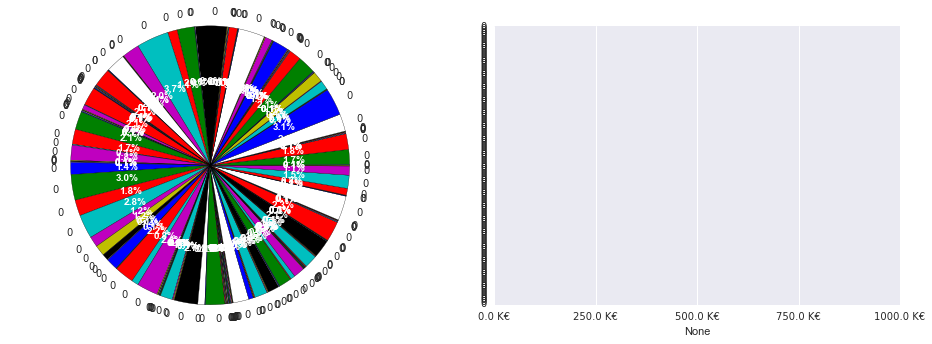

In [438]:
pie_and_strip(pc_series=s, pc_label=None, 
             strip_df=cdb, strip_col_x="actif", strip_col_y="branch", strip_label=None, 
             palette=None, explode=None, order=None,
             orient="h" )

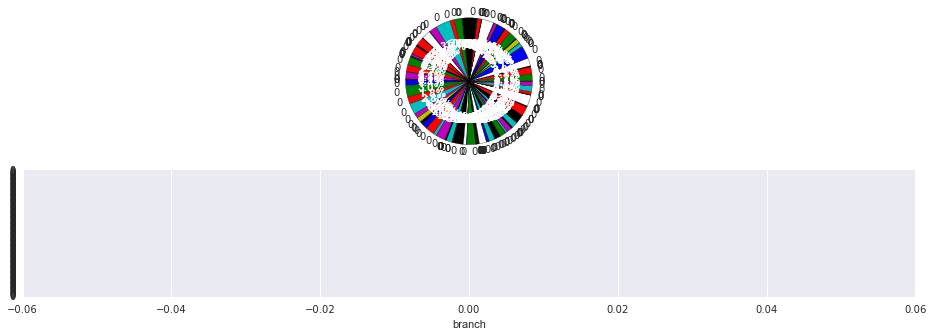

In [422]:
pie_and_count(pc_series=s, pc_label=None, 
             count_df=cdb, count_col_y="branch", count_label="branch", 
             palette=None, explode=None, order=None,
             orient="n" )

In [347]:
s = cdb.groupby("branch")["NUM_CONTRAT_BASE"].count()

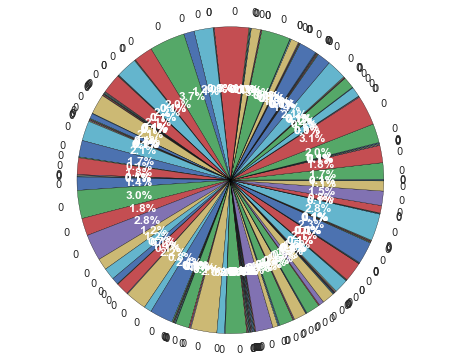

In [421]:
fig, axes = plt.subplots(1,1)
pie(axes, s, get_palette(s))


In [349]:
s = cdb.actif

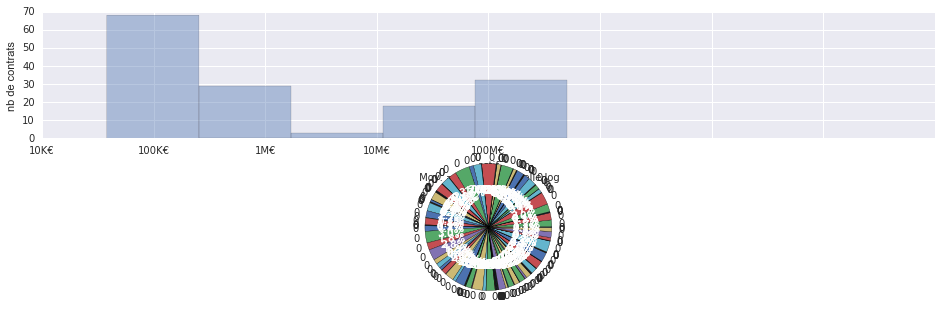

In [350]:
fig, (ax1, ax2) = get_axes_for_2_col_plot()
histo_log10_on_ax(cdb.actif, cdb.actif.name, "nb de contrats", ax=ax1);
pie(ax2, s, get_palette(s))

# 0) functions de création de tables

In [1]:
from collections import OrderedDict
pays = {"Aruba         ":"ABW",
"Afghanistan         ":"AFG",
"Angola         ":"AGO",
"Anguilla         ":"AIA",
"Åland Islands        ":"ALA",
"Albania         ":"ALB",
"Andorra         ":"AND",
"Netherlands Antilles        ":"ANT",
"United Arab Emirates       ":"ARE",
"Argentina         ":"ARG",
"Armenia         ":"ARM",
"American Samoa        ":"ASM",
"Antarctica         ":"ATA",
"French Southern Territories       ":"ATF",
"Antigua and Barbuda       ":"ATG",
"Australia         ":"AUS",
"Austria         ":"AUT",
"Azerbaijan         ":"AZE",
"Burundi         ":"BDI",
"Belgium         ":"BEL",
"Benin         ":"BEN",
"Burkina Faso        ":"BFA",
"Bangladesh         ":"BGD",
"Bulgaria         ":"BGR",
"Bahrain         ":"BHR",
"Bahamas         ":"BHS",
"Bosnia and Herzegovina       ":"BIH",
"Saint Barthélemy        ":"BLM",
"Belarus         ":"BLR",
"Belize         ":"BLZ",
"Bermuda         ":"BMU",
"Bolivia, Plurinational State of      ":"BOL",
"Brazil         ":"BRA",
"Barbados         ":"BRB",
"Brunei Darussalam        ":"BRN",
"Bhutan         ":"BTN",
"Bouvet Island        ":"BVT",
"Botswana         ":"BWA",
"Central African Republic       ":"CAF",
"Canada         ":"CAN",
"Cocos (Keeling) Islands       ":"CCK",
"Switzerland         ":"CHE",
"Chile         ":"CHL",
"China         ":"CHN",
"Côte d'Ivoire        ":"CIV",
"Cameroon         ":"CMR",
"Congo, the Democratic Republic of the    ":"COD",
"Congo         ":"COG",
"Cook Islands        ":"COK",
"Colombia         ":"COL",
"Comoros         ":"COM",
"Cape Verde        ":"CPV",
"Costa Rica        ":"CRI",
"Cuba         ":"CUB",
"Christmas Island        ":"CXR",
"Cayman Islands        ":"CYM",
"Cyprus         ":"CYP",
"Czech Republic        ":"CZE",
"Germany         ":"DEU",
"Djibouti         ":"DJI",
"Dominica         ":"DMA",
"Denmark         ":"DNK",
"Dominican Republic        ":"DOM",
"Algeria         ":"DZA",
"Ecuador         ":"ECU",
"Egypt         ":"EGY",
"Eritrea         ":"ERI",
"Western Sahara        ":"ESH",
"Spain         ":"ESP",
"Estonia         ":"EST",
"Ethiopia         ":"ETH",
"Finland         ":"FIN",
"Fiji         ":"FJI",
"Falkland Islands (Malvinas)       ":"FLK",
"France         ":"FRA",
"Faroe Islands        ":"FRO",
"Micronesia, Federated States of      ":"FSM",
"Gabon         ":"GAB",
"United Kingdom        ":"GBR",
"Georgia         ":"GEO",
"Guernsey         ":"GGY",
"Ghana         ":"GHA",
"Gibraltar         ":"GIB",
"Guinea         ":"GIN",
"Guadeloupe         ":"GLP",
"Gambia         ":"GMB",
"Guinea-Bissau         ":"GNB",
"Equatorial Guinea        ":"GNQ",
"Greece         ":"GRC",
"Grenada         ":"GRD",
"Greenland         ":"GRL",
"Guatemala         ":"GTM",
"French Guiana        ":"GUF",
"Guam         ":"GUM",
"Guyana         ":"GUY",
"Hong Kong        ":"HKG",
"Heard Island and McDonald Islands     ":"HMD",
"Honduras         ":"HND",
"Croatia         ":"HRV",
"Haiti         ":"HTI",
"Hungary         ":"HUN",
"Indonesia         ":"IDN",
"Isle of Man       ":"IMN",
"India         ":"IND",
"British Indian Ocean Territory      ":"IOT",
"Ireland         ":"IRL",
"Iran, Islamic Republic of      ":"IRN",
"Iraq         ":"IRQ",
"Iceland         ":"ISL",
"Israel         ":"ISR",
"Italy         ":"ITA",
"Jamaica         ":"JAM",
"Jersey         ":"JEY",
"Jordan         ":"JOR",
"Japan         ":"JPN",
"Kazakhstan         ":"KAZ",
"Kenya         ":"KEN",
"Kyrgyzstan         ":"KGZ",
"Cambodia         ":"KHM",
"Kiribati         ":"KIR",
"Saint Kitts and Nevis      ":"KNA",
"Korea, Republic of       ":"KOR",
"Kuwait         ":"KWT",
"Lao People's Democratic Republic      ":"LAO",
"Lebanon         ":"LBN",
"Liberia         ":"LBR",
"Libyan Arab Jamahiriya       ":"LBY",
"Saint Lucia        ":"LCA",
"Liechtenstein         ":"LIE",
"Sri Lanka        ":"LKA",
"Lesotho         ":"LSO",
"Lithuania         ":"LTU",
"Luxembourg         ":"LUX",
"Latvia         ":"LVA",
"Macao         ":"MAC",
"Saint Martin (French part)      ":"MAF",
"Morocco         ":"MAR",
"Monaco         ":"MCO",
"Moldova, Republic of       ":"MDA",
"Madagascar         ":"MDG",
"Maldives         ":"MDV",
"Mexico         ":"MEX",
"Marshall Islands        ":"MHL",
"Macedonia, the former Yugoslav Republic of    ":"MKD",
"Mali         ":"MLI",
"Malta         ":"MLT",
"Myanmar         ":"MMR",
"Montenegro         ":"MNE",
"Mongolia         ":"MNG",
"Northern Mariana Islands       ":"MNP",
"Mozambique         ":"MOZ",
"Mauritania         ":"MRT",
"Montserrat         ":"MSR",
"Martinique         ":"MTQ",
"Mauritius         ":"MUS",
"Malawi         ":"MWI",
"Malaysia         ":"MYS",
"Mayotte         ":"MYT",
"Namibia         ":"NAM",
"New Caledonia        ":"NCL",
"Niger         ":"NER",
"Norfolk Island        ":"NFK",
"Nigeria         ":"NGA",
"Nicaragua         ":"NIC",
"Niue         ":"NIU",
"Netherlands         ":"NLD",
"Norway         ":"NOR",
"Nepal         ":"NPL",
"Nauru         ":"NRU",
"New Zealand        ":"NZL",
"Oman         ":"OMN",
"Pakistan         ":"PAK",
"Panama         ":"PAN",
"Pitcairn         ":"PCN",
"Peru         ":"PER",
"Philippines         ":"PHL",
"Palau         ":"PLW",
"Papua New Guinea       ":"PNG",
"Poland         ":"POL",
"Puerto Rico        ":"PRI",
"Korea, Democratic People's Republic of     ":"PRK",
"Portugal         ":"PRT",
"Paraguay         ":"PRY",
"Palestinian Territory, Occupied       ":"PSE",
"French Polynesia        ":"PYF",
"Qatar         ":"QAT",
"Réunion         ":"REU",
"Romania         ":"ROU",
"Russian Federation        ":"RUS",
"Rwanda         ":"RWA",
"Saudi Arabia        ":"SAU",
"Sudan         ":"SDN",
"Senegal         ":"SEN",
"Singapore         ":"SGP",
"South Georgia and the South Sandwich Islands   ":"SGS",
"Saint Helena, Ascension and Tristan da Cunha   ":"SHN",
"Svalbard and Jan Mayen      ":"SJM",
"Solomon Islands        ":"SLB",
"Sierra Leone        ":"SLE",
"El Salvador        ":"SLV",
"San Marino        ":"SMR",
"Somalia         ":"SOM",
"Saint Pierre and Miquelon      ":"SPM",
"Serbia         ":"SRB",
"Sao Tome and Principe      ":"STP",
"Suriname         ":"SUR",
"Slovakia         ":"SVK",
"Slovenia         ":"SVN",
"Sweden         ":"SWE",
"Swaziland         ":"SWZ",
"Seychelles         ":"SYC",
"Syrian Arab Republic       ":"SYR",
"Turks and Caicos Islands      ":"TCA",
"Chad         ":"TCD",
"Togo         ":"TGO",
"Thailand         ":"THA",
"Tajikistan         ":"TJK",
"Tokelau         ":"TKL",
"Turkmenistan         ":"TKM",
"Timor-Leste         ":"TLS",
"Tonga         ":"TON",
"Trinidad and Tobago       ":"TTO",
"Tunisia         ":"TUN",
"Turkey         ":"TUR",
"Tuvalu         ":"TUV",
"Taiwan, Province of China      ":"TWN",
"Tanzania, United Republic of      ":"TZA",
"Uganda         ":"UGA",
"Ukraine         ":"UKR",
"United States Minor Outlying Islands     ":"UMI",
"Uruguay         ":"URY",
"United States        ":"USA",
"Uzbekistan         ":"UZB",
"Holy See (Vatican City State)     ":"VAT",
"Saint Vincent and the Grenadines     ":"VCT",
"Venezuela, Bolivarian Republic of      ":"VEN",
"Virgin Islands, British       ":"VGB",
"Virgin Islands, U.S.       ":"VIR",
"Viet Nam        ":"VNM",
"Vanuatu         ":"VUT",
"Wallis and Futuna       ":"WLF",
"Samoa         ":"WSM",
"Yemen         ":"YEM",
"South Africa        ":"ZAF",
"Zambia         ":"ZMB",
"Zimbabwe         ":"ZWE"}

In [7]:
def get_cdb_cib(n=1):
    def get_row_cdb():
        import random
        import numpy as np
        global last_cdb
        last_cdb = last_cdb +1
        branch   = ["cib"]
        score    = [ "blank", "nsc", "high", "low", "medium"]
        mil      = 1000
        million  = mil * mil
        actif    = abs(np.random.normal(50 * mil, 10 * mil))
        passif   = abs(np.random.normal(100 * mil, 25 * mil))
        a_p      = actif + passif
        r = {   "branch" : random.choice(branch),
                "score"   : random.choice(score),
                 "actif"            :   actif ,
                 "passif"           : passif ,
                 "actif + passif"   : a_p,
                 "NUM_CONTRAT_BASE" : last_cdb
            }
        return r
    df = pd.DataFrame([get_row_cdb() for i in range(n)])
    return df

In [8]:
def get_cdb_retail(n=1):
    def get_row_cdb():
        import random
        import numpy as np
        global last_cdb
        last_cdb = last_cdb +1
        branch   = ["retail"]
        score    = [ "blank", "nsc", "high", "low"]
        mil      = 1000
        million  = mil * mil
        actif    = abs(np.random.normal(35 * mil, 10 * mil))
        passif   = abs(np.random.normal(50 * mil, 5 * mil))
        a_p      = actif + passif
        r = {   "branch" : random.choice(branch),
                "score"   : random.choice(score),
                 "actif"            : actif ,
                 "passif"           : passif ,
                 "actif + passif"   : a_p,
                 "NUM_CONTRAT_BASE" : last_cdb
            }
        return r
    df = pd.DataFrame([get_row_cdb() for i in range(n)])
    return df

In [9]:
def get_cdb_wealth(n=1):
    def get_row_cdb():
        import random
        import numpy as np
        global last_cdb
        last_cdb = last_cdb +1
        branch   = ["wealth"]
        score    = [ "blank", "nsc", "high", "low"]
        mil      = 1000
        million  = mil * mil
        actif    = abs(np.random.normal(million, million/2))
        passif   = abs(np.random.normal(10 * million, 5*million))
        a_p      = actif + passif
        r = {   "branch" : random.choice(branch),
                "score"   : random.choice(score),
                 "actif"            :   actif ,
                 "passif"           : passif ,
                 "actif + passif"   : a_p,
                 "NUM_CONTRAT_BASE" : last_cdb
            }
        return r
    df = pd.DataFrame([get_row_cdb() for i in range(n)])
    return df

In [10]:
def get_cdb(n=1):
    import random
    type_contrat = [get_cdb_wealth, get_cdb_retail, get_cdb_cib]
    df = pd.concat([random.choice(type_contrat)() for i in range(n)])
    return df

In [11]:
def get_lien(liste_client, n=1):
    def get_row_lien(liste_client):
        import random
        r = {
            "ID_ACTEUR"     : random.choice(liste_client),
            "ID_ACTEUR_LIE" : random.choice(liste_client),
            "lien"          : random.choice(["p->f", "m->f", "p->e"])
        }
        return r
    df = pd.DataFrame([get_row_lien(liste_client) for i in range(n)])
    return df

In [384]:
def get_row_ubo(liste_client):
    import random
    r = {
        "ID_ACTEUR"       : random.choice(liste_client),
        "ID_ACTEUR_BENEF" : random.choice(liste_client),
        "v"               : random.randint(0,1000)
    }
    return r

In [394]:
def get_row_tit(liste_client, liste_contrat):
    return get_row_roles(liste_client, liste_contrat, ["TIT"])

def get_row_non_tit(liste_client, liste_contrat):
    return get_row_roles(liste_client, liste_contrat, ["MANDATAIRE", "REPR", "TIT2", ])


def get_row_roles(liste_client, liste_contrat, roles):
    import random
    r = {
        "ID_ACTEUR"           : random.choice(liste_client),
        "NUMERO_CONTRAT_BASE" : random.choice(liste_contrat),
        "date"                : random.randint(0,1000),
        "role"                : random.choice(roles),
    }
    return r

In [395]:
def get_acteur(acteur_type):
    import random
    global last_id
    import numpy as np
    import datetime
    last_id = last_id +1
    countries = ["GER", "FR","BEL","LUX","LUX","LUX","LUX","LUX","LUX","RUS","CHI","AND","ARE","ARG","ARM","ASM","ATA","ATF","ATG","AUS","AUT","AZE","BDI","BEL","BEN","BES","BFA"]
    
    import math
    def get_alea():
        return int(math.floor(np.random.normal(5, 3)))
    pays_imat = get_alea()
    pays_domicile = get_alea()
    pays_residence = get_alea()
    pays_activite = get_alea()
    return {
        "ID client": last_id +1,
        "type_acteur" : acteur_type,
        "age" : random.randint(10,100), 
        "code pays immatriculation" : countries[pays_imat],
        "Code Pays residence fiscale" : countries[pays_residence],
        "Code Pays domicile" : countries[pays_domicile],
        "Code Pays Secteur activite" : countries[pays_activite],
        "Date entree relation affaire" : datetime.datetime.fromordinal(random.randint(1993*365, 365*2018))
    }
def get_acteur_pp():
    return get_acteur("P")
    
def get_acteur_pm():
    return get_acteur("M")

In [396]:
import datetime
import random
datetime.datetime.fromordinal(random.randint(1993*365, 365*2018))

datetime.datetime(2017, 8, 2, 0, 0)

# 1) création des tables

In [423]:
nb_acteurs = 200
nb_cdb     = 300
nb_ubos    = 10
nb_liens   = 0

In [424]:
import pandas as pd
last_id  = 0
last_cdb = 0
acteurs  = pd.DataFrame([get_acteur_pm() if not i%5 else get_acteur_pp() for i in range(nb_acteurs)])
cdb      = get_cdb(nb_cdb)
roles    = pd.DataFrame([get_row_non_tit(acteurs['ID client'].values, cdb["NUM_CONTRAT_BASE"].values) if not i%3 else get_row_tit(acteurs['ID client'].values, cdb["NUM_CONTRAT_BASE"].values) for i in range(nb_cdb*2)])
ubos     = pd.DataFrame([get_row_ubo(acteurs["ID client"].values) for i in range(nb_ubos)])
liens    = get_lien(acteurs["ID client"].values, 10)

# 2) présentation des tables

## 2.1) exemples de lignes (en mode transposées)

In [425]:
nombre_d_exemple=2

In [426]:
n = nombre_d_exemple
print("="*50) ; print("table acteurs :") ; print(acteurs.head(n).T )
print("="*50) ; print("table cdb :")     ; print(cdb.head(n).T     )
print("="*50) ; print("table roles :")   ; print(roles.head(n).T   )
print("="*50) ; print("table ubos :")    ; print(ubos.head(n).T    )
print("="*50) ; print("table liens :")   ; print(liens.head(n).T   ) 

table acteurs :
                                                0                    1
Code Pays Secteur activite                    LUX                   FR
Code Pays domicile                            GER                  ASM
Code Pays residence fiscale                   AND                  BDI
Date entree relation affaire  1996-03-27 00:00:00  1996-11-06 00:00:00
ID client                                       2                    3
age                                            27                   70
code pays immatriculation                     BEL                  BEL
type_acteur                                     M                    P
table cdb :
                            0            0
NUM_CONTRAT_BASE            1            2
actif             1.30508e+06  1.00359e+06
actif + passif    1.33866e+07  5.26323e+06
branch                 wealth       wealth
passif            1.20815e+07  4.25964e+06
score                    high          nsc
table roles :
                  

In [427]:
roles.index = roles.NUMERO_CONTRAT_BASE
cdb.index = cdb.NUM_CONTRAT_BASE
role_cdb = roles.join(cdb)

In [428]:
role_cdb.index= role_cdb.ID_ACTEUR
acteurs.index = acteurs["ID client"]
acteurs_role_cdb = acteurs.join(role_cdb)

In [429]:
acteurs_role_cdb

,Code Pays Secteur activite,Code Pays domicile,Code Pays residence fiscale,Date entree relation affaire,ID client,age,code pays immatriculation,type_acteur,ID_ACTEUR,NUMERO_CONTRAT_BASE,date,role,NUM_CONTRAT_BASE,actif,actif + passif,branch,passif,score
2,LUX,GER,AND,1996-03-27,2,27,BEL,M,2.0,115.0,135.0,MANDATAIRE,115.0,4.807232e+04,9.332236e+04,cib,4.525004e+04,medium
3,FR,ASM,BDI,1996-11-06,3,70,BEL,P,3.0,109.0,424.0,TIT,109.0,1.974059e+06,8.968110e+06,wealth,6.994051e+06,low
3,FR,ASM,BDI,1996-11-06,3,70,BEL,P,3.0,143.0,859.0,TIT,143.0,3.164335e+04,7.328170e+04,retail,4.163835e+04,high
3,FR,ASM,BDI,1996-11-06,3,70,BEL,P,3.0,168.0,838.0,TIT,168.0,5.039500e+04,9.956299e+04,retail,4.916798e+04,nsc
3,FR,ASM,BDI,1996-11-06,3,70,BEL,P,3.0,213.0,714.0,TIT,213.0,5.653691e+04,9.558746e+04,retail,3.905055e+04,high
4,LUX,LUX,AZE,1993-03-16,4,31,LUX,P,4.0,64.0,970.0,TIT,64.0,3.499078e+04,8.946366e+04,retail,5.447288e+04,blank
4,LUX,LUX,AZE,1993-03-16,4,31,LUX,P,4.0,109.0,205.0,TIT,109.0,1.974059e+06,8.968110e+06,wealth,6.994051e+06,low
4,LUX,LUX,AZE,1993-03-16,4,31,LUX,P,4.0,155.0,809.0,TIT,155.0,4.088111e+04,1.514186e+05,cib,1.105375e+05,blank
4,LUX,LUX,AZE,1993-03-16,4,31,LUX,P,4.0,170.0,66.0,TIT,170.0,3.785358e+04,8.887937e+04,retail,5.102578e+04,nsc
4,LUX,LUX,AZE,1993-03-16,4,31,LUX,P,4.0,189.0,484.0,TIT2,189.0,6.100048e+04,1.718424e+05,cib,1.108419e+05,high


# 2.2) nombre de lignes et noms des colonnes

In [430]:
print("acteurs: %s"% str(acteurs.shape ))
print("cdb: %s"% str(cdb.shape ))
print("roles: %s"% str(roles.shape ))
print("ubos: %s"% str(ubos.shape ))
print("liens: %s"% str(liens.shape ))

acteurs: (200, 8)
cdb: (300, 6)
roles: (600, 4)
ubos: (10, 3)
liens: (10, 3)


In [431]:
sep = ", "
print("acteurs:\n %s\n"% sep.join(acteurs.columns.values ))
print("cdb:\n %s\n"% sep.join(cdb.columns.values ))
print("roles:\n %s\n"% sep.join(roles.columns.values ))
print("ubos:\n %s\n"% sep.join(ubos.columns.values ))
print("liens:\n %s\n"% sep.join(liens.columns.values ))

acteurs:
 Code Pays Secteur activite, Code Pays domicile, Code Pays residence fiscale, Date entree relation affaire, ID client, age, code pays immatriculation, type_acteur

cdb:
 NUM_CONTRAT_BASE, actif, actif + passif, branch, passif, score

roles:
 ID_ACTEUR, NUMERO_CONTRAT_BASE, date, role

ubos:
 ID_ACTEUR, ID_ACTEUR_BENEF, v

liens:
 ID_ACTEUR, ID_ACTEUR_LIE, lien



# Division en pm / pp

In [432]:
def get_pm(df):
    return df[df["type_acteur"] == "M"]
def get_pp(df):
    return df[df["type_acteur"] == "P"]

# Distribution_des_clients_selon_la_date_d_immatriculation_PM

In [433]:


def plot_count_selon_date(ax, df,   col_clef, col_date, **kwargs):
    """
    1) resample df on a yearly basis
    2) duplicates row on [col_clef, col_date]
    3) count the number of deduplicated rows on a yearly basis
    4) plot a dashed line on the given ax
    """
    %matplotlib inline 
    frequency    = "A"
    linestyle    = "dashed"
    marker       = 'o'
    subset       = df[[col_clef, col_date]]
    subset.index = subset[col_date]
    subset       = subset.drop_duplicates()
    count        = subset.resample(frequency).count()
    title = kwargs["title"]
    count[col_date].plot(linestyle=linestyle, marker=marker, ax=ax,title=title)

def plot_by_business_line(df, plot_function, col_branch="branch", **kwargs):
    """
    1) cree a fig with 3 subplots
    2) loop over the df to subset it for each branch
    3) call the given function (plotting) for each of the 3 subset,
        passing each of the 3 differents axes for each 3 subsets
    """
    print(kwargs)
    branches = ('wealth', 'cib', 'retail')
    import matplotlib.pyplot as plt
    fig, axes    = plt.subplots(1,3, figsize=(15, 5), sharey=True)
    current_axe  = -1
    for branch in branches:
        current_axe = current_axe +1
        ax          = axes[current_axe]
        sub_df      = df[df[col_branch] == branch]
        title       = "%s "%(branch)
        kwargs["title"] = "%s \n %s"%(branch, kwargs["sujet"])
        plot_function(ax=ax, df=sub_df,  **kwargs)
    return fig    


In [434]:
def get_3_subset(df, col_branch="branch"):
    from collections import OrderedDict
    branches = ('wealth', 'cib', 'retail')
    r        = OrderedDict()
    for branch in branches:
        r[branch] = df[df[col_branch] == branch]
    return r    


In [436]:
pm

,Code Pays Secteur activite,Code Pays domicile,Code Pays residence fiscale,Date entree relation affaire,ID client,age,code pays immatriculation,type_acteur,ID_ACTEUR_m1,ID_ACTEUR_LIE,...,score,ID_ACTEUR_m6,NUMERO_CONTRAT_BASE_role_lie,date_role_lie,role_role_lie,ID_ACTEUR_role_lie_2,NUMERO_CONTRAT_BASE,date,role,anciennete
0,LUX,LUX,BFA,2001-04-02,2,12,LUX,M,NaN,NaN,...,nsc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6196.0
6,LUX,LUX,LUX,2009-12-17,7,35,LUX,M,7.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3015.0
7,LUX,LUX,LUX,2009-12-17,7,35,LUX,M,7.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3015.0
13,LUX,LUX,LUX,1996-05-29,12,17,LUX,M,12.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7965.0
14,LUX,LUX,LUX,1996-05-29,12,17,LUX,M,12.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7965.0
19,GER,LUX,RUS,1999-07-16,17,14,BEL,M,NaN,NaN,...,high,NaN,NaN,NaN,NaN,17.0,5.0,796.0,MANDATAIRE,6822.0


In [435]:
df       = pm
function = plot_count_selon_date
sujet    = "PM : nb clients selon date d immatriculation"
col_clef = "ID client"
col_date = "Date entree relation affaire"
plot_by_business_line(df       ,  
                      function ,
                      col_clef = col_clef , 
                      col_date = col_date ,
                      sujet    = sujet    )
    



{'col_clef': 'ID client', 'sujet': 'PM : nb clients selon date d immatriculation', 'col_date': 'Date entree relation affaire'}


TypeError: Empty 'DataFrame': no numeric data to plot

{'col_clef': 'ID client', 'sujet': 'PP : nb clients selon date d immatriculation', 'col_date': 'Date entree relation affaire'}


/Users/romain/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=28.0, right=28.0
  'left=%s, right=%s') % (left, right))


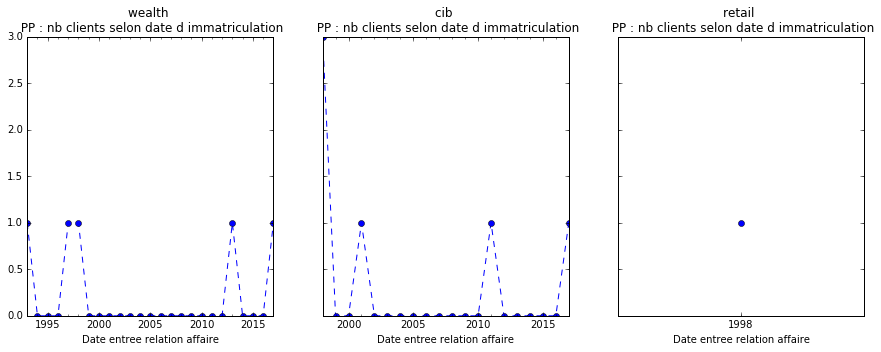

In [47]:
df       = pp
function = plot_count_selon_date
sujet    = "PP : nb clients selon date d immatriculation"
col_clef = "ID client"
col_date = "Date entree relation affaire"
plot_by_business_line(df       ,  
                      function ,
                      col_clef = col_clef , 
                      col_date = col_date ,
                      sujet    = sujet    )
    

# 4	Distribution_des_clients_selon_l_anciennete_de_la_relation_PM

In [48]:
current_date         = datetime.datetime.strptime("2018/03/20", "%Y/%m/%d")
merge7["anciennete"] = current_date - merge7["Date entree relation affaire"] 
merge7["anciennete"] = merge7["anciennete"] / pd.Timedelta(days=1)

In [49]:
pm = merge7[merge7["type_acteur"] == "M"]
pp = merge7[merge7["type_acteur"] == "P"]

In [50]:
def distribution_par__pp_pm(full_df, col_to_plot, col_branch="branch", col_acteur="type_acteur", title=""):
    """
    1) Divise la df en pp et pm, 
    2) appel distplot_by_branch_subset sur chaque sous df
    """
    from collections import OrderedDict
    distplot_by_branch_subset(title , full_df, col_to_plot)
    r = OrderedDict()
    r["pm"] = full_df[full_df[col_acteur] == "M"]
    r["pp"] = full_df[full_df[col_acteur] == "P"]
    for acteur, subset in r.items():
           distplot_by_branch_subset(title + " (acteurs = %s)"%acteur, subset, col_to_plot)

def  distplot_by_branch_subset(title, df, col_to_plot, col_branch="branch"):
    """
    1) crée une figure a trois colonne
    2) divise la df en 3 parties (pour chaque branche)
    3) appel distplot pour chaque branche sur une des 3 graphique de la figure
    """
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1,3, sharey=True, figsize=(15,5))
    fig.suptitle(title, fontsize=16)
    print(title)
    current_axe = -1
    sujet       = title
    for branch, subset in get_3_subset(df, col_branch=col_branch).items():
        title       = branch + "\n(%s,%s)"%subset.shape
        current_axe = current_axe + 1
        ax          = axes[current_axe]
        ax.set_title(title)
        import seaborn as sns
        sns.distplot(subset[col_to_plot], kde=False, rug=False,ax=ax)


Distribution_des_clients_selon_l_anciennete_de_la_relation


TypeError: len() of unsized object

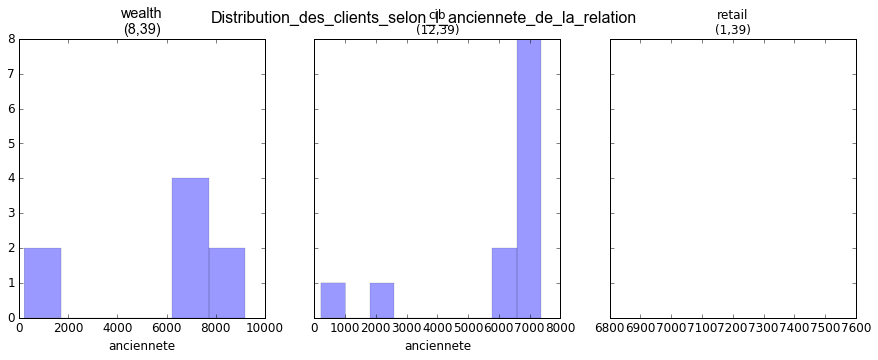

In [51]:
distribution_par__pp_pm(merge7, "anciennete", title="Distribution_des_clients_selon_l_anciennete_de_la_relation")

In [52]:
merge7.shape

(33, 39)

Distribution_actif_brut_PM


TypeError: len() of unsized object

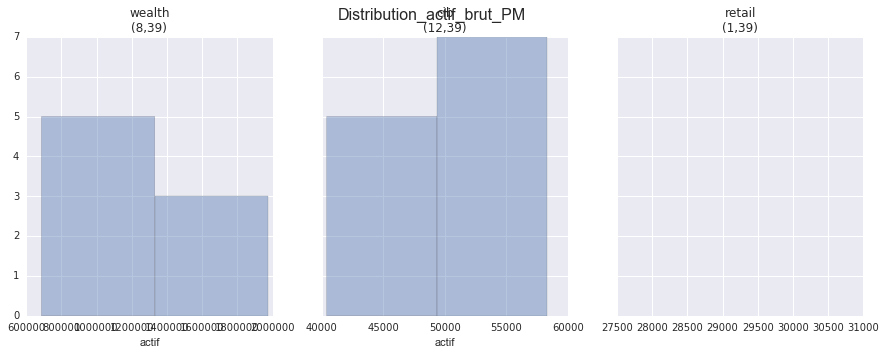

In [53]:
distribution_par__pp_pm(merge7, 'actif', title="Distribution_actif_brut_PM")

In [209]:
import seaborn as sns

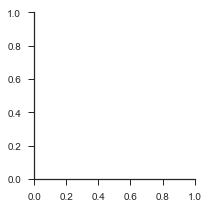

In [210]:
sns.FacetGrid(merge7, )

In [211]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)

In [212]:
tips = sns.load_dataset("tips")

In [213]:
tips.head(2)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3


The basic workflow is to initialize the FacetGrid object with the dataset and the variables that are used to structure the grid. Then one or more plotting functions can be applied to each subset by calling FacetGrid.map() or FacetGrid.map_dataframe(). Finally, the plot can be tweaked with other methods to do things like change the axis labels, use different ticks, or add a legend. See the detailed code examples below for more information.

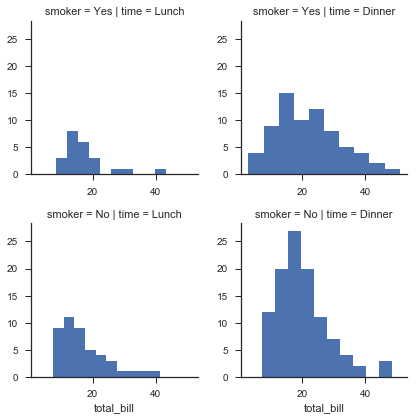

In [214]:
import matplotlib.pyplot as plt
g = sns.FacetGrid(tips, col="time", row="smoker")
g = g.map(plt.hist, "total_bill", linestyle="dashed")

In [215]:
merge7.columns

Index(['Code Pays Secteur activite', 'Code Pays domicile',
       'Code Pays residence fiscale', 'Date entree relation affaire',
       'ID client', 'age', 'code pays immatriculation', 'type_acteur',
       'ID_ACTEUR_m1', 'ID_ACTEUR_LIE', 'lien', 'ID_ACTEUR_2',
       'ID_ACTEUR_LIE_2', 'lien_2', 'ID_ACTEUR_ubo', 'ID_ACTEUR_BENEF_m2',
       'v_m2', 'ID_ACTEUR_m3', 'ID_ACTEUR_BENEF_ubo', 'v_ubo',
       'ID_ACTEUR_role', 'NUMERO_CONTRAT_BASE_m5', 'date_m5', 'role_m5',
       'NUM_CONTRAT_BASE', 'actif', 'actif + passif', 'branch', 'passif',
       'score', 'ID_ACTEUR_m6', 'NUMERO_CONTRAT_BASE_role_lie',
       'date_role_lie', 'role_role_lie', 'ID_ACTEUR_role_lie_2',
       'NUMERO_CONTRAT_BASE', 'date', 'role', 'anciennete'],
      dtype='object')

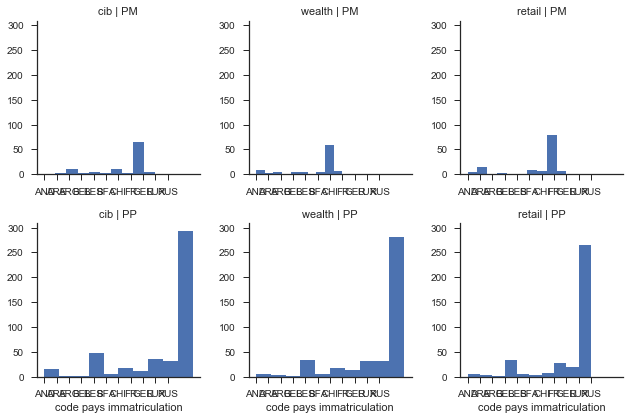

In [216]:
import matplotlib.pyplot as plt
g = sns.FacetGrid(merge7, col="branch", row="type_acteur", palette="Set1")
g = g.map(plt.hist, "code pays immatriculation")
g.set_titles(template="{col_name} | P{row_name}");

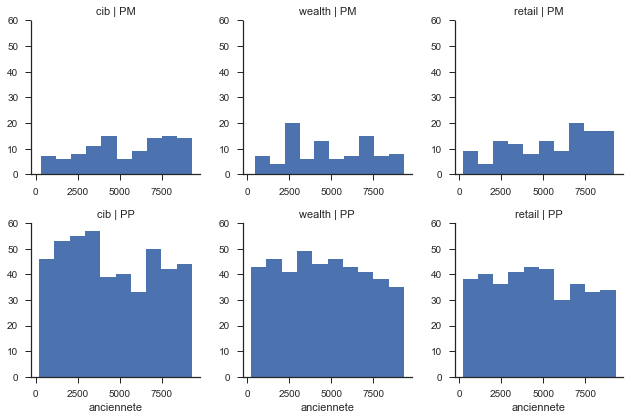

In [217]:
import matplotlib.pyplot as plt
g = sns.FacetGrid(merge7, col="branch", row="type_acteur", palette="Set1",)
g = g.map(plt.hist, "anciennete")
g.set_titles(template="{col_name} | P{row_name}");


In [218]:
disp_col(cdb)

0) NUM_CONTRAT_BASE
1) actif
2) actif + passif
3) branch
4) passif
5) score


In [219]:
disp_col(roles)

0) ID_ACTEUR
1) NUMERO_CONTRAT_BASE
2) date
3) role


In [220]:
disp_col(acteurs)

0) Code Pays Secteur activite
1) Code Pays domicile
2) Code Pays residence fiscale
3) Date entree relation affaire
4) ID client
5) age
6) code pays immatriculation
7) type_acteur


In [221]:
cdb_role = pd.merge(cdb, roles, left_on="NUM_CONTRAT_BASE", right_on="NUMERO_CONTRAT_BASE", how="left")

In [222]:
cdb_role_infos = pd.merge(cdb_role, acteurs, left_on="ID_ACTEUR", right_on="ID client", how="left")

# 0)	clients	Nombre de clients PP et PM par business line

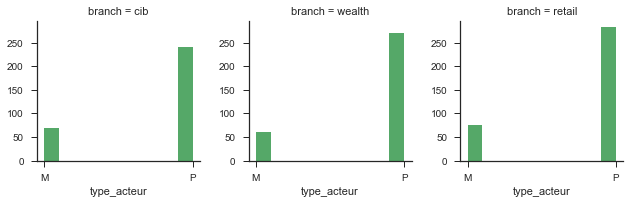

In [223]:
g = sns.FacetGrid(titulaires, col="branch",  palette="Set1",)
g = g.map(plt.hist, "type_acteur", color="g")

# 1)		Nombre de clients PP et PM par business line et AUM correspondants

In [224]:
titulaires = cdb_role_infos[cdb_role_infos.role == "TIT"]

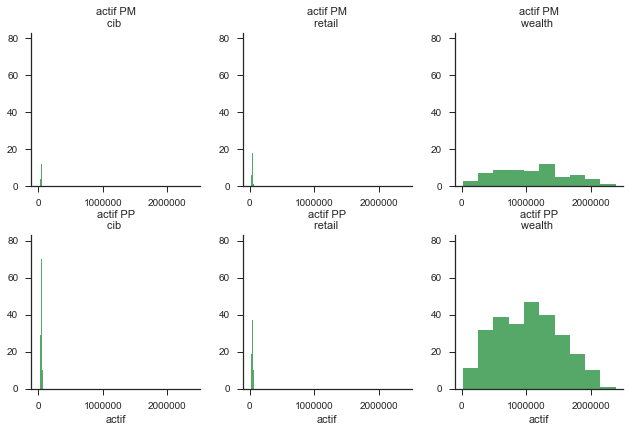

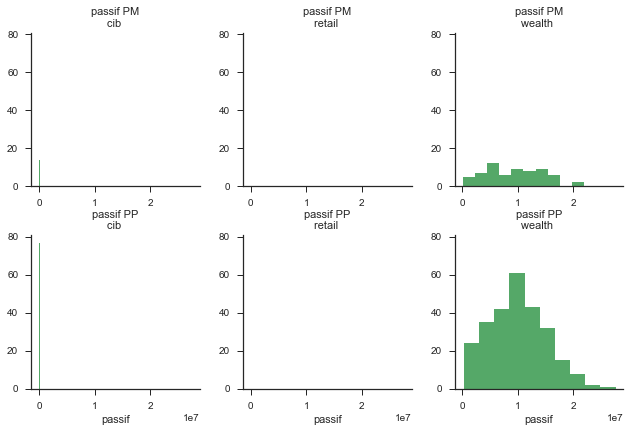

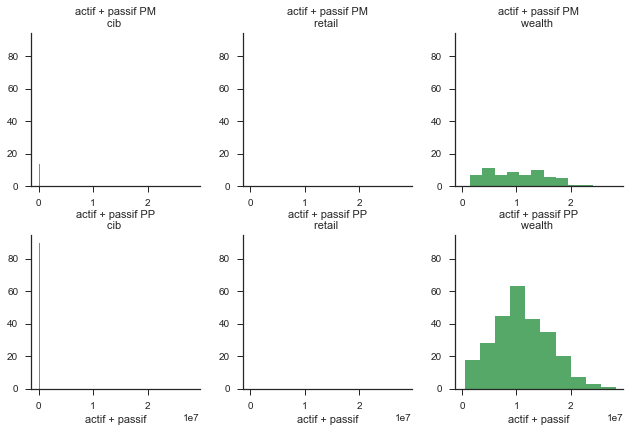

In [225]:
infos = ["actif", "passif", "actif + passif"]
for info in infos :
    import matplotlib.pyplot as plt
    g = sns.FacetGrid(titulaires, col="branch", row="type_acteur", palette="Set1",)
    g = g.map(plt.hist, info, color="g")
    g.set_titles(template="%s P{row_name}\n{col_name} "%info);

# 2	Répartition des clients PP et PM par score de risque AML

In [236]:
titulaires.score.value_counts()

low       239
high      233
blank     228
nsc       224
medium     76
Name: score, dtype: int64

In [237]:
titulaires = cdb_role_infos[cdb_role_infos.role == "TIT"]

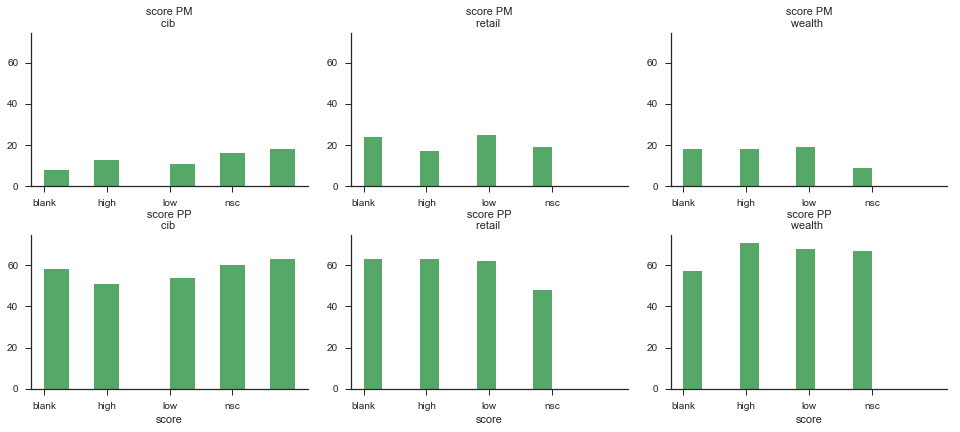

In [238]:
info = "score"
g = sns.FacetGrid(titulaires, col="branch", row="type_acteur", palette="Set1",aspect=1.5)
g = g.map(plt.hist, info, color="g")
g.set_titles(template="%s P{row_name}\n{col_name} "%info);

# 3		Nombre de clients sans score de risque (voir procédure risk scoring page 5 2.4 et 2.5) par sous-catégorie et par business line   

# 4) Répartition de la clientèle entre résidents et non-résidents (critère de résidence fiscale) 

In [245]:
mot_luxembourg = "LUX"
titulaires.loc[:,"residents"] = titulaires["Code Pays domicile"]==mot_luxembourg

/Users/romain/anaconda/envs/python35/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


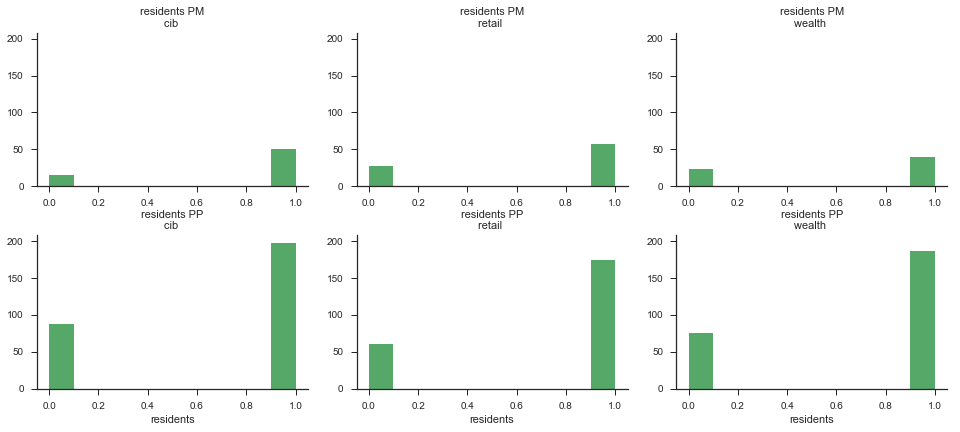

In [266]:
info = "residents"
g = sns.FacetGrid(titulaires, col="branch", row="type_acteur", palette="Set1",aspect=1.5)
g = g.map(plt.hist, info, color="g")
g.set_titles(template="%s P{row_name}\n{col_name} "%info);

# 4.1) Répartition de la clientèle entre résidents entre nationaux et étrangers (critère de nationalité)

In [269]:
col_de_test      = "Code nationalite 1"
mot_clef         = "LUX"
nouvelle_colonne =  "etranger"

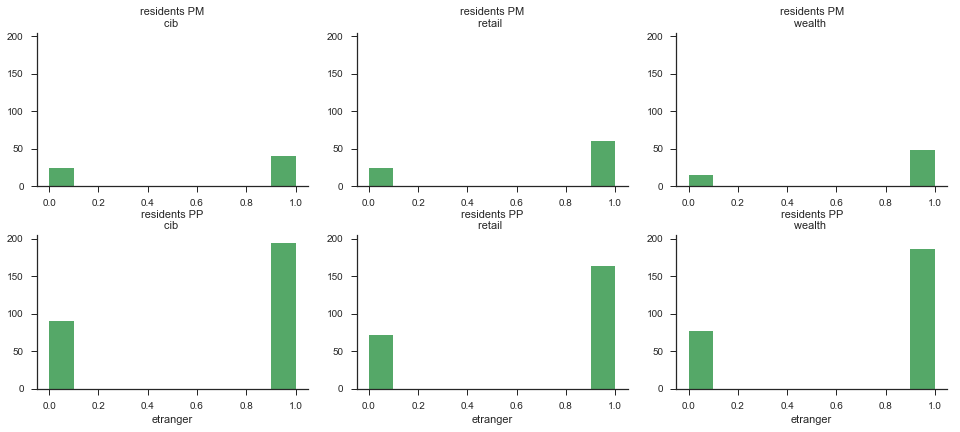

In [276]:
cdb_role_infos.loc[:,nouvelle_colonne] = cdb_role_infos[col_de_test]==mot_clef
titulaires = cdb_role_infos[cdb_role_infos.role == "TIT"]
g = sns.FacetGrid(titulaires, col="branch", row="type_acteur", palette="Set1",aspect=1.5)
g = g.map(plt.hist, nouvelle_colonne, color="g")
g.set_titles(template="%s P{row_name}\n{col_name} "%info);

# 5) Nombre de clients PP et PM  avec une résidence fiscale dans un pays à risque élevé (fournir les noms des pays concernés avec les effectifs correspondants)

In [285]:
col_de_test      = 'Code Pays residence fiscale'
mot_clef         = ["RUS","CHI","AND","ARE","ARG","ARM","ASM","ATA"]
nouvelle_colonne =  "residence_fiscale_en_pays_risque"
info             =    nouvelle_colonne.replace("_", " ")

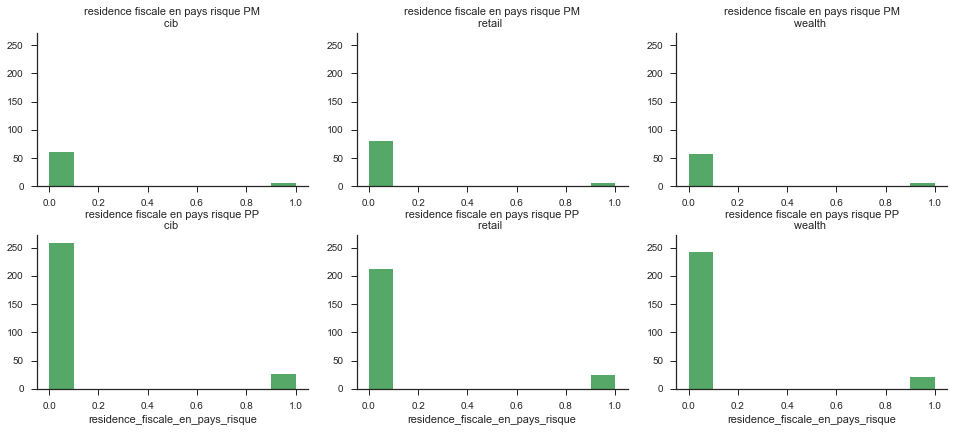

In [286]:
cdb_role_infos.loc[:,nouvelle_colonne] = cdb_role_infos[col_de_test].isin(mot_clef)
titulaires = cdb_role_infos[cdb_role_infos.role == "TIT"]
g = sns.FacetGrid(titulaires, col="branch", row="type_acteur", palette="Set1",aspect=1.5)
g = g.map(plt.hist, nouvelle_colonne, color="g")
g.set_titles(template="%s P{row_name}\n{col_name} "%info);


# 5,1)  PP et PM et AUM correspondants avec une résidence fiscale dans un pays à risque élevé (fournir les noms des pays concernés avec les effectifs correspondants)

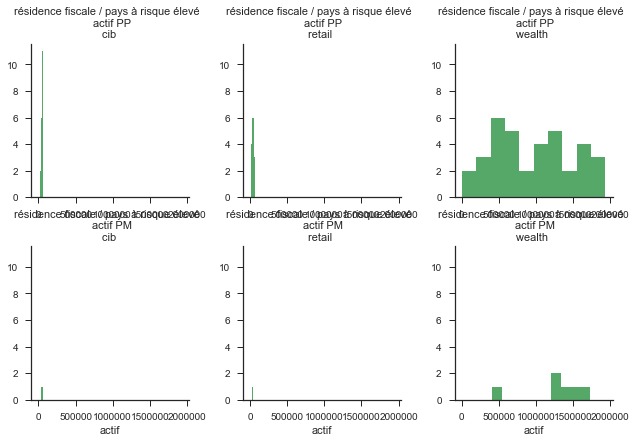

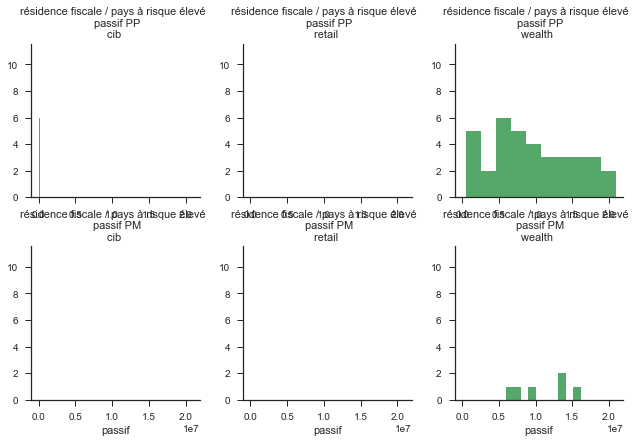

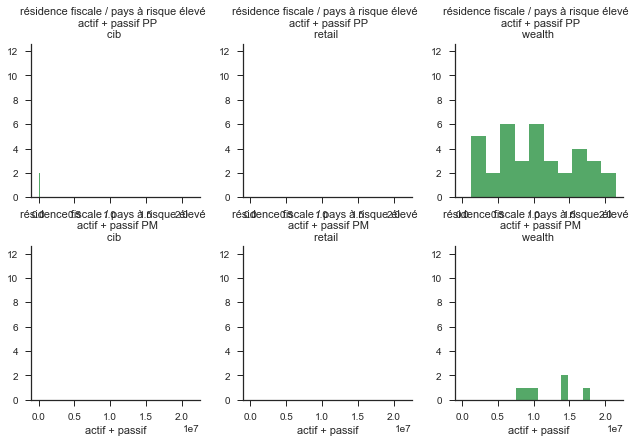

In [294]:
subset = cdb_role_infos[cdb_role_infos.residence_fiscale_en_pays_risque]
infos = ["actif", "passif", "actif + passif"]
for info in infos :
    import matplotlib.pyplot as plt
    g = sns.FacetGrid(subset, col="branch", row="type_acteur", palette="Set1",)
    g = g.map(plt.hist, info, color="g")
    g.set_titles(template="résidence fiscale / pays à risque élevé  \n %s P{row_name}\n{col_name} "%info);

# # 6) Distribution des clients PP selon leur âge (+ donner âge moyen)

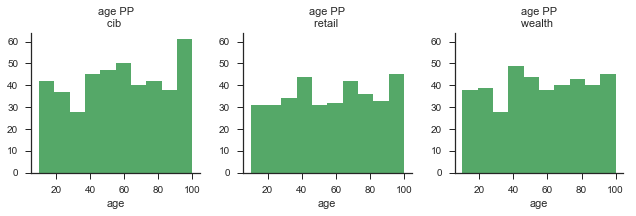

In [307]:
subset = cdb_role_infos[cdb_role_infos.type_acteur=="P"]
infos = ["age"]
for info in infos :
    import matplotlib.pyplot as plt
    g = sns.FacetGrid(subset, col="branch", row="type_acteur", palette="Set1",)
    g = g.map(plt.hist, info, color="g")
    g.set_titles(template="%s P{row_name}\n{col_name} "%info);

In [318]:
#âge moyen
subset.groupby("branch")[infos[0]].mean()

branch
cib       56.734884
retail    56.320334
wealth    55.900990
Name: age, dtype: float64

# 7) Distribution des clients selon leur âge et présence de mandataires

In [324]:
titulaires =  cdb_role_infos[cdb_role_infos.role=="TIT"]

In [330]:
contrat_avec_mandataires = roles[roles.role=="MANDATAIRE"]
infos_titulaires = cdb_role_infos[cdb_role_infos.NUMERO_CONTRAT_BASE.isin(titulaires.NUM_CONTRAT_BASE)]

In [336]:
infos_contrat_avec_mandataire = infos_titulaires[infos_titulaires.NUM_CONTRAT_BASE.isin(contrat_avec_mandataires.NUMERO_CONTRAT_BASE)]
infos_contrat_sans_mandataire = infos_titulaires[~infos_titulaires.NUM_CONTRAT_BASE.isin(contrat_avec_mandataires.NUMERO_CONTRAT_BASE)]

In [346]:
infos_titulaires = infos_contrat_avec_mandataire[infos_contrat_avec_mandataire.role=="TIT"]
a = infos_titulaires.groupby(["age", "role"])["NUM_CONTRAT_BASE"].count()

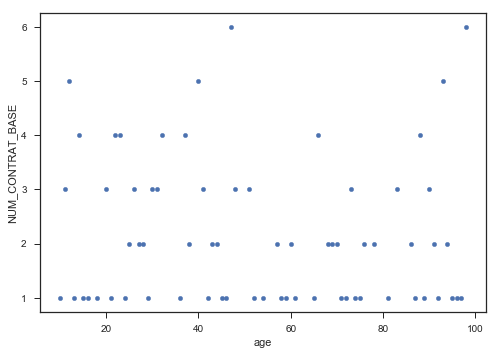

In [350]:
a.reset_index().plot.scatter(x="age", y="NUM_CONTRAT_BASE")

# 8) Distribution des clients selon l'ancienneté de la relation PP /PM par business line

In [351]:
current_date         = datetime.datetime.strptime("2018/03/20", "%Y/%m/%d")
cdb_role_infos["anciennete"] = current_date - cdb_role_infos["Date entree relation affaire"] 
cdb_role_infos["anciennete"] = cdb_role_infos["anciennete"] / pd.Timedelta(days=1)

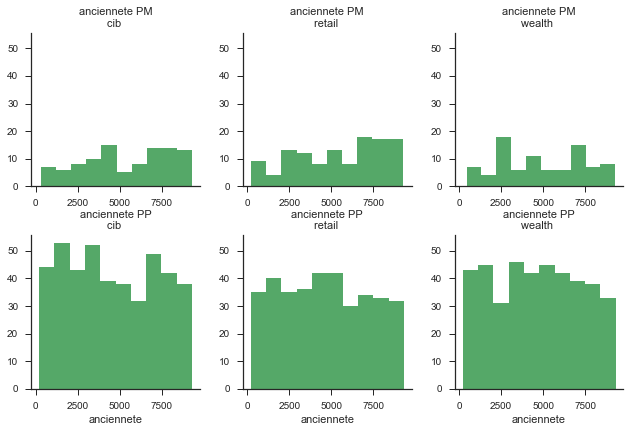

In [359]:
subset = cdb_role_infos
infos = ["anciennete"]
for info in infos :
    import matplotlib.pyplot as plt
    g = sns.FacetGrid(subset, col="branch", row="type_acteur", palette="Set1",)
    g = g.map(plt.hist, info, color="g")
    g.set_titles(template="%s P{row_name}\n{col_name} "%info);




# 9) Distribution des clients selon l'ancienneté d’immatriculation des PM par business line

# 10) Répartition des PP par nationalité (effectifs par nom de pays)

In [375]:

subset = cdb_role_infos[cdb_role_infos.type_acteur=="P"]
subset = subset.groupby(["branch", "Code nationalite 1"])["ID client"].count()
subset = a.reset_index()
subset = subset.sort_values("ID client", ascending=False)
subset.head(2)

,index,branch,Code nationalite 1,ID client
0,11,cib,LUX,282
1,33,wealth,LUX,282


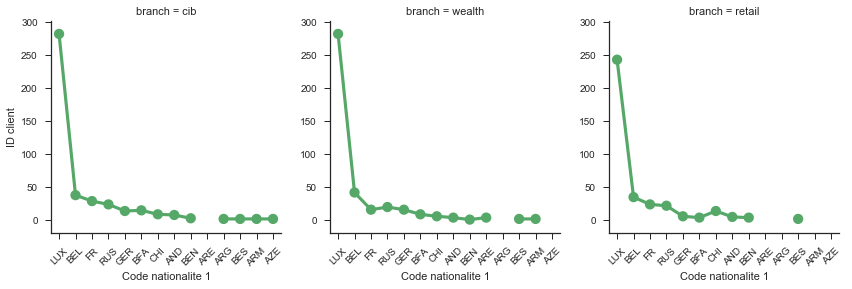

In [376]:
infos = ["Code nationalite 1"]
for info in infos :
    import matplotlib.pyplot as plt
    g = sns.factorplot(col="branch", x="Code nationalite 1",y="ID client", data=subset, color="g")
    g.set_xticklabels(rotation=45)

# 11) Répartition des PM par pays d'immatriculation  (effectifs par nom de pays)

In [433]:
sujet       = u"(11) Répartition des PM par pays d'immatriculation"
info        = "code pays immatriculation"
type_acteur = "M"

subset = cdb_role_infos[cdb_role_infos.type_acteur==type_acteur]
subset = subset.groupby(["branch", info])["ID client"].count()
subset = subset.reset_index()
subset = subset.sort_values("ID client", ascending=False)
subset.head(2)

,branch,code pays immatriculation,ID client
17,retail,LUX,77
8,cib,LUX,62


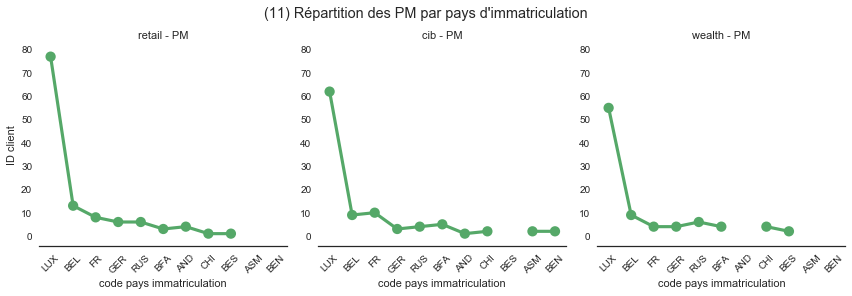

In [434]:

g = sns.factorplot(col="branch", x=info,y="ID client", data=subset, color="g", title="coucou")
g.set_xticklabels(rotation=45)
g.set_titles("{col_name} - P%s"%type_acteur).despine(left=True)

plt.subplots_adjust(top=0.85)
g.fig.suptitle(sujet);

# 12) % des PM immatriculés dans les pays à risque élevé

In [435]:
sujet = u"% des PM immatriculés dans les pays à risque élevé"
col_de_test      = 'Code Pays residence fiscale'
mot_clef         = ["RUS","CHI","AND","ARE","ARG","ARM","ASM","ATA"]
nouvelle_colonne =  "residence_fiscale_en_pays_risque"
info             =    nouvelle_colonne.replace("_", " ")

cdb_role_infos.loc[:,nouvelle_colonne] = cdb_role_infos[col_de_test].isin(mot_clef)
titulaires = cdb_role_infos[cdb_role_infos.role == "TIT"]
subset = titulaires[titulaires.type_acteur=="M"]



In [464]:

a = subset.groupby(["type_acteur", "branch", "residence_fiscale_en_pays_risque"])["NUM_CONTRAT_BASE"].count()

In [468]:
b = a.groupby(level=[0, 1]).apply(lambda x: x / x.sum())

In [469]:
c = b.reset_index()

In [470]:
c

,type_acteur,branch,residence_fiscale_en_pays_risque,NUM_CONTRAT_BASE
0,M,cib,False,0.924242
1,M,cib,True,0.075758
2,M,retail,False,0.941176
3,M,retail,True,0.058824
4,M,wealth,False,0.906250
5,M,wealth,True,0.093750


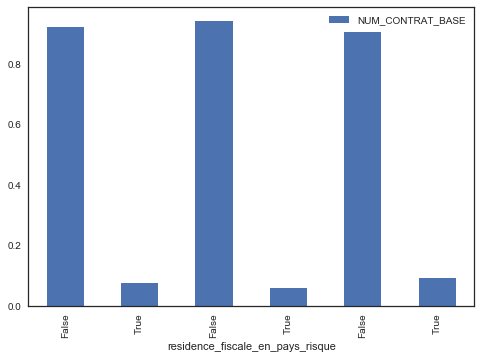

In [471]:
c.plot.bar(x="residence_fiscale_en_pays_risque", y = "NUM_CONTRAT_BASE")

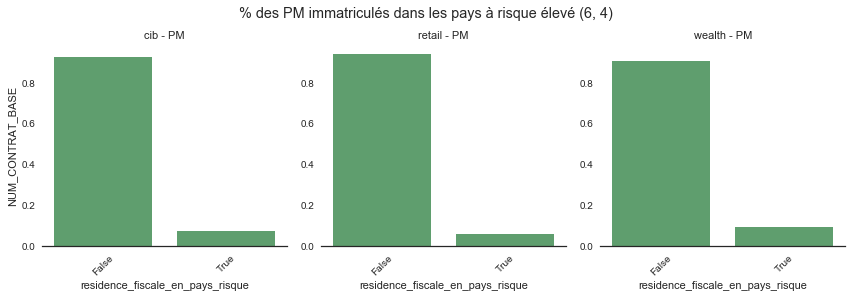

In [474]:

g = sns.factorplot(col="branch", x="residence_fiscale_en_pays_risque",y="NUM_CONTRAT_BASE", data=c, color="g", kind="bar")
g.set_xticklabels(rotation=45)
g.set_titles("{col_name} - P%s"%type_acteur).despine(left=True)

plt.subplots_adjust(top=0.85)
g.fig.suptitle(sujet + " (%s, %s)"%c.shape);

# 13) Distribution des PM selon le chiffre d'affaires

In [475]:
disp_col(cdb_role_infos)

0) NUM_CONTRAT_BASE
1) actif
2) actif + passif
3) branch
4) passif
5) score
6) ID_ACTEUR
7) NUMERO_CONTRAT_BASE
8) date
9) role
10) Code Pays Secteur activite
11) Code Pays domicile
12) Code Pays residence fiscale
13) Date entree relation affaire
14) ID client
15) age
16) code pays immatriculation
17) type_acteur
18) Code nationalite 1
19) etranger
20) residence_fiscale_en_pays_risque
21) anciennete


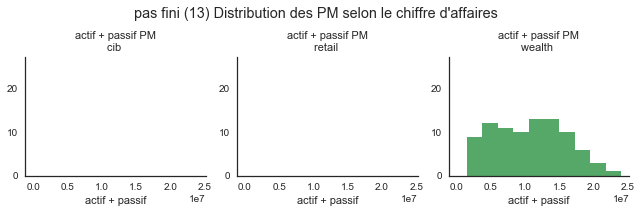

In [483]:
sujet = u"pas fini (13) Distribution des PM selon le chiffre d'affaires "
subset = cdb_role_infos[cdb_role_infos.type_acteur=="M"]
infos = ["actif + passif"]
for info in infos :
    import matplotlib.pyplot as plt
    g = sns.FacetGrid(subset, col="branch", row="type_acteur", palette="Set1",)
    g = g.map(plt.hist, info, color="g")
    g.set_titles(template="%s P{row_name}\n{col_name} "%info);
plt.subplots_adjust(top=0.75)
g.fig.suptitle(sujet );    

# 14) Résidence fiscale des UBO (top 10 pays à risque élevé et effectifs correspondant)

In [ ]:
sujet       = u"(14) Résidence fiscale des UBO (top 10 pays à risque élevé et effectifs correspondant"
info        = "code pays immatriculation"
type_acteur = "M"

subset = cdb_role_infos[cdb_role_infos.type_acteur==type_acteur]
subset = subset.groupby(["branch", info])["ID client"].count()
subset = subset.reset_index()
subset = subset.sort_values("ID client", ascending=False)
subset.head(2)

In [ ]:

g = sns.factorplot(col="branch", x=info,y="ID client", data=subset, color="g", title="coucou")
g.set_xticklabels(rotation=45)
g.set_titles("{col_name} - P%s"%type_acteur).despine(left=True)

plt.subplots_adjust(top=0.85)
g.fig.suptitle(sujet);

In [505]:
cdb_role_infos.shape

(2049, 22)

In [510]:
deux_acteurs  = acteurs[:2]

In [527]:
deux_acteurs  = acteurs[acteurs["ID client"].isin([5, 6])]
deux_acteurs  

,Code Pays Secteur activite,Code Pays domicile,Code Pays residence fiscale,Date entree relation affaire,ID client,age,code pays immatriculation,type_acteur
3,FR,LUX,LUX,2000-02-22,5,98,CHI,P
4,LUX,LUX,RUS,2010-10-07,6,89,LUX,P


In [560]:
deux_roles = roles[roles.ID_ACTEUR.isin([5,6])]
deux_roles.index = deux_roles.NUMERO_CONTRAT_BASE
deux_roles

,ID_ACTEUR,NUMERO_CONTRAT_BASE,date,role,NUM_CONTRAT_BASE
NUMERO_CONTRAT_BASE,,,,,
121538,6,121538,725,TIT,121538
24168,5,24168,392,TIT,24168
136796,5,136796,51,TIT,136796


In [543]:
deux_contrats = cdb[cdb.NUM_CONTRAT_BASE.isin([121538,24168, 136796, 10 ])]
deux_contrats.index = deux_contrats.NUM_CONTRAT_BASE
deux_contrats

,NUM_CONTRAT_BASE,actif,actif + passif,branch,passif,score
NUM_CONTRAT_BASE,,,,,,
10,10,5.629431e+04,1.386557e+05,cib,8.236143e+04,medium
24168,24168,1.737768e+06,2.369476e+07,wealth,2.195700e+07,blank
121538,121538,1.241400e+06,1.754986e+07,wealth,1.630846e+07,blank
136796,136796,3.598926e+05,1.852948e+07,wealth,1.816958e+07,high


In [545]:
deux_contrats.join(deux_roles)

,NUM_CONTRAT_BASE,actif,actif + passif,branch,passif,score,ID_ACTEUR,NUMERO_CONTRAT_BASE,date,role
NUM_CONTRAT_BASE,,,,,,,,,,
10,10,5.629431e+04,1.386557e+05,cib,8.236143e+04,medium,NaN,NaN,NaN,NaN
24168,24168,1.737768e+06,2.369476e+07,wealth,2.195700e+07,blank,5.0,24168.0,392.0,TIT
121538,121538,1.241400e+06,1.754986e+07,wealth,1.630846e+07,blank,6.0,121538.0,725.0,TIT
136796,136796,3.598926e+05,1.852948e+07,wealth,1.816958e+07,high,5.0,136796.0,51.0,TIT


In [558]:
roles["NUM_CONTRAT_BASE"] = roles.NUMERO_CONTRAT_BASE

In [562]:
pd.merge(deux_contrats, deux_roles, left_on="NUM_CONTRAT_BASE", right_on="NUMERO_CONTRAT_BASE", how="right", suffixes=("contrats", "roles"))

,NUM_CONTRAT_BASEcontrats,actif,actif + passif,branch,passif,score,ID_ACTEUR,NUMERO_CONTRAT_BASE,date,role,NUM_CONTRAT_BASEroles
0,24168,1.737768e+06,2.369476e+07,wealth,2.195700e+07,blank,5,24168,392,TIT,24168
1,121538,1.241400e+06,1.754986e+07,wealth,1.630846e+07,blank,6,121538,725,TIT,121538
2,136796,3.598926e+05,1.852948e+07,wealth,1.816958e+07,high,5,136796,51,TIT,136796


In [566]:
cdb = cdb.reset_index(drop=True)

In [572]:
cdb.head()

,NUM_CONTRAT_BASE,actif,actif + passif,branch,passif,score
0,1,1.305076e+06,1.338656e+07,wealth,1.208149e+07,high
1,2,1.003591e+06,5.263233e+06,wealth,4.259642e+06,nsc
2,3,5.494040e+04,1.169719e+05,cib,6.203152e+04,nsc
3,4,4.219694e+04,8.973610e+04,cib,4.753916e+04,high
4,5,4.817243e+04,1.016326e+05,retail,5.346015e+04,high


In [583]:
cdb.pivot_table(index="NUM_CONTRAT_BASE", values="score", aggfunc=lambda x: len(x))

NUM_CONTRAT_BASE
1      1
2      1
3      1
4      1
5      1
6      1
7      1
8      1
9      1
10     1
11     1
12     1
13     1
14     1
15     1
16     1
17     1
18     1
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     1
27     1
28     1
29     1
30     1
      ..
271    1
272    1
273    1
274    1
275    1
276    1
277    1
278    1
279    1
280    1
281    1
282    1
283    1
284    1
285    1
286    1
287    1
288    1
289    1
290    1
291    1
292    1
293    1
294    1
295    1
296    1
297    1
298    1
299    1
300    1
Name: score, dtype: int64

In [576]:
def nb_contrat(data):
    #print(data)
    return len(data)

In [577]:
var =cdb.pivot_table(index=["branch", "score"],  
                     values=["actif", "passif", ], 
                     aggfunc=[nb_contrat, np.mean, min, max, np.std,  np.count_nonzero], 
                     margins=True)
var

nb_contrat                 mean                          min  \
                   actif passif         actif        passif          actif   
branch score                                                                 
cib    blank        15.0   15.0  4.784167e+04  8.978714e+04   24507.621827   
       high         15.0   15.0  5.107623e+04  8.903779e+04   39068.693338   
       low          26.0   26.0  5.141909e+04  9.105254e+04   38466.505278   
       medium       21.0   21.0  4.835391e+04  9.357040e+04   29957.772181   
       nsc          20.0   20.0  4.875694e+04  8.843672e+04   35165.711714   
retail blank        20.0   20.0  3.190215e+04  5.046006e+04   11188.162887   
       high         29.0   29.0  3.876531e+04  5.017027e+04   21021.157816   
       low          22.0   22.0  3.539704e+04  5.254898e+04   15420.864349   
       nsc          34.0   34.0  3.533569e+04  4.992109e+04     740.253063   
wealth blank        28.0   28.0  8.587606e+05  1.131898e+07  101057.368808   
       high         33.0   33.0  9.657266e+05  8.524736e+06   82599.844529   
       low          18.0   18.0  1.032089e+06  1.011868e+07   67765.092055   
       nsc          19.0   19.0  1.040361e+06  9.511768e+06   40258.397156   
All                300.0  300.0  3.427079e+05  3.250695e+06     740.253063   

                                      max                          std  \
                     passif         actif        passif          actif   
branch score                                                             
cib    blank   2.858052e+04  6.507587e+04  1.394487e+05   11072.238189   
       high    2.762554e+04  6.806840e+04  1.683312e+05    9345.426686   
       low     5.569983e+04  6.710345e+04  1.321055e+05    7451.618590   
       medium  4.525004e+04  7.470362e+04  1.254909e+05   10901.493719   
       nsc     4.532612e+04  6.638022e+04  1.338683e+05    9322.599263   
retail blank   3.866512e+04  6.580820e+04  5.990014e+04   10586.967584   
       high    3.905055e+04  6.842864e+04  6.074576e+04   11134.970912   
       low     4.364598e+04  5.311870e+04  5.926431e+04    9769.002682   
       nsc     4.252970e+04  5.460981e+04  5.735734e+04   12351.744984   
wealth blank   3.577066e+06  1.725775e+06  2.387664e+07  446769.016322   
       high    2.939038e+05  2.079926e+06  1.881550e+07  541901.138016   
       low     6.545836e+05  1.974059e+06  1.806464e+07  491915.951565   
       nsc     1.602367e+05  2.013325e+06  1.727237e+07  527295.608132   
All            2.762554e+04  2.079926e+06  2.387664e+07  517133.715545   

                            count_nonzero         
                     passif         actif passif  
branch score                                      
cib    blank   3.265521e+04          15.0   15.0  
       high    3.660237e+04          15.0   15.0  
       low     2.039611e+04          26.0   26.0  
       medium  2.384527e+04          21.0   21.0  
       nsc     2.026693e+04          20.0   20.0  
retail blank   6.257336e+03          20.0   20.0  
       high    5.679122e+03          29.0   29.0  
       low     4.139598e+03          22.0   22.0  
       nsc     3.810003e+03          34.0   34.0  
wealth blank   5.131317e+06          28.0   28.0  
       high    5.023787e+06          33.0   33.0  
       low     4.637720e+06          18.0   18.0  
       nsc     4.792057e+06          19.0   19.0  
All            5.377742e+06         300.0  300.0

In [516]:
var.unstack().unstack().reset_index()

,level_0,score,branch,0
0,actif,blank,cib,7.176250e+05
1,actif,blank,retail,6.380430e+05
2,actif,blank,wealth,2.404530e+07
3,actif,high,cib,7.661434e+05
4,actif,high,retail,1.124194e+06
5,actif,high,wealth,3.186898e+07
6,actif,low,cib,1.336896e+06
7,actif,low,retail,7.787350e+05
8,actif,low,wealth,1.857760e+07
9,actif,medium,cib,1.015432e+06


In [509]:
var.unstack().stack(level=0).reset_index()

score,branch,level_1,blank,high,low,medium,nsc
0,cib,actif,7.176250e+05,7.661434e+05,1.336896e+06,1.015432e+06,9.751388e+05
1,cib,actif + passif,2.064432e+06,2.101710e+06,3.704262e+06,2.980410e+06,2.743873e+06
2,cib,passif,1.346807e+06,1.335567e+06,2.367366e+06,1.964978e+06,1.768734e+06
3,retail,actif,6.380430e+05,1.124194e+06,7.787350e+05,NaN,1.201414e+06
4,retail,actif + passif,1.647244e+06,2.579132e+06,1.934813e+06,NaN,2.898731e+06
5,retail,passif,1.009201e+06,1.454938e+06,1.156078e+06,NaN,1.697317e+06
6,wealth,actif,2.404530e+07,3.186898e+07,1.857760e+07,NaN,1.976686e+07
7,wealth,actif + passif,3.409766e+08,3.131853e+08,2.007139e+08,NaN,2.004905e+08
8,wealth,passif,3.169313e+08,2.813163e+08,1.821362e+08,NaN,1.807236e+08


In [501]:
pd.melt?

In [510]:
var2=var.unstack().stack(level=0).reset_index()
pd.melt(var2, id_vars=["branch","level_1"])

,branch,level_1,score,value
0,cib,actif,blank,7.176250e+05
1,cib,actif + passif,blank,2.064432e+06
2,cib,passif,blank,1.346807e+06
3,retail,actif,blank,6.380430e+05
4,retail,actif + passif,blank,1.647244e+06
5,retail,passif,blank,1.009201e+06
6,wealth,actif,blank,2.404530e+07
7,wealth,actif + passif,blank,3.409766e+08
8,wealth,passif,blank,3.169313e+08
9,cib,actif,high,7.661434e+05
